# Assignment A/B Testing

Pertanyaan yang Ingin Dijawab

Apakah campaign ini berhasil?

Jika berhasil, sejauh mana keberhasilan tersebut bisa dikaitkan dengan penayangan iklan?

Untuk menjawab hal ini, dilakukan pembagian kelompok:

Ad group (experimental group): mayoritas pengguna akan melihat iklan.

PSA group (control group): sebagian kecil pengguna hanya melihat pengumuman publik (PSA) atau tidak ada iklan sama sekali, dengan posisi dan ukuran yang sama seperti slot iklan.

Dengan membandingkan kedua kelompok, kita bisa menganalisis apakah iklan benar-benar efektif mendorong konversi, seberapa besar potensi keuntungan dari iklan, dan apakah perbedaannya signifikan secara statistik.

General information

Index → nomor urut baris data.

user id → identitas unik untuk setiap pengguna.

test group → grup percobaan:

"ad" = user masuk grup eksperimen (melihat iklan).

"psa" = user masuk grup kontrol (melihat PSA atau tidak ada iklan).

converted → hasil akhir:

True = user membeli produk (berhasil dikonversi).

False = user tidak membeli.

total ads → jumlah total iklan yang dilihat oleh user.

most ads day → hari ketika user melihat iklan terbanyak (misalnya Senin, Selasa, dst).

most ads hour → jam (0–23) ketika user melihat iklan terbanyak (misalnya jam 18 artinya pukul 18:00).

## Import from Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import library

In [ ]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

## 1. Basic Data Understanding

In [ ]:
#Membaca data
df = pd.read_csv('/content/drive/MyDrive/DATA SET/marketing_AB.csv')

In [ ]:
#menampilkan 5 data pertama
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [ ]:
# menampilkan informasi tentang data yang digunakan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [ ]:
shape = df.shape
print(f"Jumlah baris: {shape[0]}")
print(f"Jumlah kolom: {shape[1]}")

Jumlah baris: 588101
Jumlah kolom: 5


## 2. Cek Duplicate & Missing Values

## Duplicate Data

In [ ]:
duplicate = len(df[df.duplicated()])
print(f"Jumlah data duplikat:, {duplicate} rows")

Jumlah data duplikat:, 0 rows


## Missing Value

In [ ]:
# Cek missing value
missing_value = df.isna().sum()
print(missing_value)

Unnamed: 0       0
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64


## 3. Drop Unwanted Columns

In [ ]:
# Drop Unwated Columns
df.drop(['Unnamed: 0', 'user id'], axis=1, inplace=True)

In [ ]:
df.columns

Index(['test group', 'converted', 'total ads', 'most ads day',
       'most ads hour'],
      dtype='object')

## 5. Menentukan Object A/B Testing

In [ ]:
df['converted'] = df['converted'].astype(int)

In [ ]:
print("Distribusi jumlah dan persentase tiap group:")
print(pd.crosstab(index=df['test group'], columns="count", normalize=False))

print("\nPersentase tiap group:")
print(pd.crosstab(index=df['test group'], columns="percentage", normalize=True) * 100)

print("\nConversion rate tiap group (%):")
print((df.groupby('test group')['converted'].mean() * 100).round(2))


Distribusi jumlah dan persentase tiap group:
col_0        count
test group        
ad          564577
psa          23524

Persentase tiap group:
col_0       percentage
test group            
ad           96.000007
psa           3.999993

Conversion rate tiap group (%):
test group
ad     2.55
psa    1.79
Name: converted, dtype: float64


Nilai rata-rata pada kolom converted adalah 0.0252, yang berarti sekitar 2,52% pengguna dalam dataset melakukan konversi.

Distribusi data menunjukkan ada sekitar 564.577 entri (96%) pada kelompok ad, sedangkan kelompok psa hanya berjumlah 23.524 entri (4%).

Tingkat konversi pada kelompok ad tercatat 2,55%, sementara pada kelompok psa lebih rendah yaitu 1,79%.

Dalam studi ini terdapat dua kelompok pengguna yang diuji:

Ad group = pengguna melihat iklan.

PSA group = pengguna tidak melihat iklan, melainkan hanya pengumuman lain (atau bahkan tidak ada iklan sama sekali).

Kedua kelompok ini dibandingkan menggunakan metode A/B Testing untuk mengevaluasi efektivitas iklan.

Ada beberapa pertanyaan utama yang bisa diuji:

Efektivitas iklan: apakah tingkat konversi pada kelompok yang melihat iklan (ad group) lebih tinggi dibandingkan dengan kelompok psa? Dengan kata lain, apakah iklan memang mendorong pembelian produk?

Paparan iklan dan konversi: apakah terdapat perbedaan jumlah iklan yang dilihat antara pengguna yang akhirnya membeli produk (converted) dan yang tidak?

Hasil dari pengujian ini akan membantu menentukan apakah iklan benar-benar memberikan dampak signifikan terhadap pembelian. Jika iya, maka strategi iklan dapat diteruskan bahkan ditingkatkan. Namun, jika tidak ada perbedaan berarti, maka pengeluaran untuk iklan dapat dipertimbangkan untuk dikurangi.

### 6. Efektivitas Iklan terhadap Conversion



Hipotesis:

H0 (Null Hypothesis): Tidak ada perbedaan tingkat konversi antara kelompok yang melihat iklan (ad) dan kelompok yang tidak melihat iklan (psa). Dengan kata lain, iklan tidak berpengaruh pada tingkat konversi.

H1 (Alternative Hypothesis): Terdapat perbedaan tingkat konversi antara kelompok ad dan psa. Artinya, iklan berpengaruh terhadap tingkat konversi.

Kelompok Uji:

Independent group (variabel bebas): jenis paparan iklan → ad vs psa.

Target group (variabel terikat): status konversi → converted (True/False).

Sample Size:

Tingkat kepercayaan: 95% (α = 0.05)

Margin of Error: ±1% (karena conversion rate hanya sekitar 1.7%–2.5%, perlu ukuran sampel yang cukup besar).

Sampel terpilih:

ad group = 9.444 pengguna

psa group = 6.820 pengguna

Metode Pengambilan Sampel:

Data diacak menggunakan fungsi .sample() agar representatif dan mengurangi bias.

In [ ]:
ad_group  = df[df['test group'] == 'ad']['converted'].sample(9444, random_state=42)
psa_group = df[df['test group'] == 'psa']['converted'].sample(6820, random_state=42)

In [ ]:
ad_group.reset_index().sample(10)

,index,converted
7550,268371,0
7988,560733,0
733,166209,0
7276,289671,0
7537,549071,0
3320,574504,0
9080,495861,0
2221,544690,0
1954,450481,0
3479,67689,0


In [ ]:
psa_group.reset_index().sample(10)

,index,converted
4342,394155,0
3256,78030,0
4905,21312,0
5249,43097,0
5411,188487,0
2778,36090,0
878,553145,0
2254,547031,0
6095,410848,0
4123,69796,0


Membuat subset dataframe (df_cat) hanya dengan kolom kategorikal yang penting dan Menghitung jumlah nilai unik di setiap kolom subset tersebut.

In [ ]:
df_cat = df[['test group', 'converted', 'most ads day', 'most ads hour']]
df_cat.nunique()

,0
test group,2
converted,2
most ads day,7
most ads hour,24


In [ ]:
# mengecek kategori unik dari setiap kolom di df_cat
for i in df_cat.columns:
    print(i.upper(), ":", df_cat[i].unique())

TEST GROUP : ['ad' 'psa']
CONVERTED : [0 1]
MOST ADS DAY : ['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday']
MOST ADS HOUR : [20 22 18 10 14 13 19 11 12 16 21  3 23  4  8  0  2 15  1  6 17  7  9  5]


## Univariate analysis

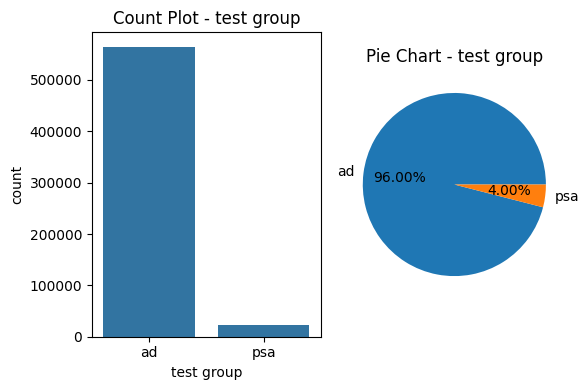

In [ ]:
# menentukan variabel yang akan dipakai
variable = 'test group'
plt.figure(figsize=(6, 4))

# --- Count Plot ---
plt.subplot(1, 2, 1)
# membuat count plot untuk variabel yang ditentukan dari dataframe
sns.countplot(x=variable, data=df_cat)
# judul pada count plot
plt.title(f'Count Plot - {variable}')

# --- Pie Chart ---
# subplot pada posisi ke-2 dari grid 1x2
plt.subplot(1, 2, 2)
# jumlah data unik pada variabel yang ditentukan
counts = df_cat[variable].value_counts()
# pie chart dengan label dan persentase
plt.pie(counts, labels=counts.index, autopct='%0.2f%%')
# judul pada pie chart
plt.title(f'Pie Chart - {variable}')

# layout agar judul dan label tidak saling tumpang tindih
plt.tight_layout()

# plot
plt.show()


Mayoritas data di test group adalah kategori ad, dengan jumlah lebih dari 550.000 observasi.

Sementara itu, kategori psa hanya sekitar 20.000–25.000 observasi.

Artinya distribusi sampel sangat tidak seimbang antara dua kelompok ini.

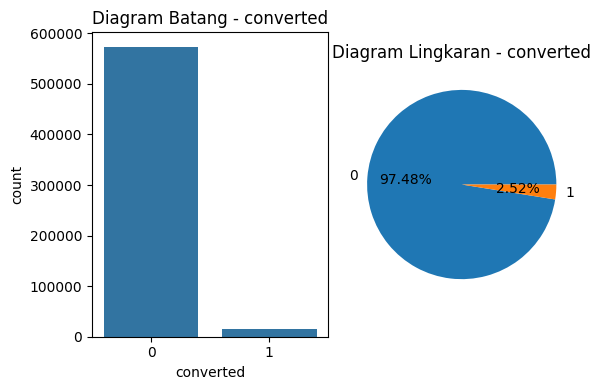

In [ ]:
# Tentukan variabel yang akan dianalisis
variable = 'converted'
plt.figure(figsize=(6, 4))

# --- Diagram Batang (Count Plot) ---
plt.subplot(1, 2, 1)
# count plot untuk variabel 'converted'
sns.countplot(x=variable, data=df_cat)
# judul untuk diagram batang
plt.title(f'Diagram Batang - {variable}')

# --- Diagram Lingkaran (Pie Chart) ---
# subplot kedua pada grid 1x2
plt.subplot(1, 2, 2)
# jumlah masing-masing nilai unik pada kolom 'converted'
counts = df_cat[variable].value_counts()
# diagram lingkaran dari hasil perhitungan
plt.pie(counts, labels=counts.index, autopct='%0.2f%%')
# judul untuk diagram lingkaran
plt.title(f'Diagram Lingkaran - {variable}')

# layout agar tampilan rapi dan tidak bertumpuk
plt.tight_layout()

# plot yang sudah dibuat
plt.show()


Nilai 0 (tidak converted) jumlahnya sangat dominan, hampir 600.000.

Nilai 1 (converted) jumlahnya jauh lebih sedikit, sekitar 15.000-an saja.

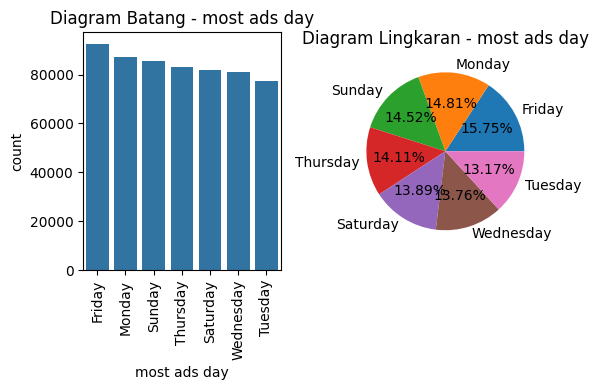

In [ ]:
variable = "most ads day"

plt.figure(figsize=(6, 4))

# Diagram Batang (Count Plot)
plt.subplot(1, 2, 1)
sns.countplot(x=variable, data=df_cat, order=df_cat['most ads day'].value_counts().index)
plt.title(f"Diagram Batang - {variable}")
plt.xticks(rotation=90)  # Putar label sumbu X agar terbaca jelas

# Diagram Lingkaran (Pie Chart)
plt.subplot(1, 2, 2)
counts = df_cat[variable].value_counts()
plt.pie(counts, labels=counts.index, autopct="%0.2f%%")
plt.title(f"Diagram Lingkaran - {variable}")

# Atur tata letak agar rapi
plt.tight_layout()

# Tampilkan plot
plt.show()


Jumlah iklan paling banyak muncul di hari Jumat, sekitar 90 ribuan.

Setelah itu berturut-turut Senin, Minggu, dan Kamis dengan jumlah relatif mirip (80–85 ribuan).

Hari dengan iklan paling sedikit adalah Selasa, disusul Rabu dan Sabtu.

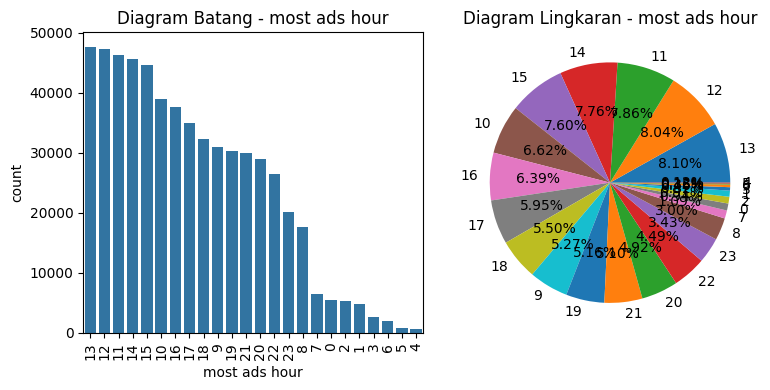

In [ ]:
variable = 'most ads hour'

plt.figure(figsize=(8, 4))

# Diagram Batang (Count Plot)
plt.subplot(1, 2, 1)
sns.countplot(x=variable, data=df_cat, order=df_cat['most ads hour'].value_counts().index)
plt.title(f'Diagram Batang - {variable}')
plt.xticks(rotation=90)

# Diagram Lingkaran (Pie Chart)
plt.subplot(1, 2, 2)
counts = df_cat[variable].value_counts()
plt.pie(counts, labels=counts.index, autopct='%0.2f%%')
plt.title(f'Diagram Lingkaran - {variable}')

# tata letak agar rapi
plt.tight_layout()

# Tampilkan plot
plt.show()


Jam 12–15 siang (12, 13, 14, 15) adalah periode dengan iklan paling banyak tayang, masing-masing hampir 50.000 kali.

Setelah itu jumlah tayangan menurun bertahap dari sore ke malam (16–20).

Tengah malam hingga pagi dini hari (0–5) sangat sedikit, bahkan hampir nol di jam 4–5.

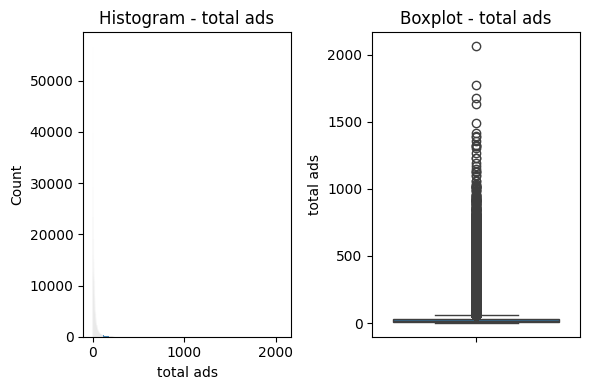

In [ ]:
variable = 'total ads'

plt.figure(figsize = (6, 4))
# Histogram
plt.subplot(1, 2, 1)
sns.histplot(x=variable, data=df)
plt.title(f'Histogram - {variable}')

# Pie chart (Note: This comment refers to a Pie chart, but the code generates a Boxplot)
plt.subplot(1, 2, 2)
sns.boxplot(y = variable, data = df)
plt.title(f'Boxplot - {variable}') # Title correctly identifies it as a Boxplot

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

dari boxplot tersebut tidak terlihat

In [ ]:
# Cek statistik deskriptif fitur
df['total ads'].describe()

,total ads
count,588101.000000
mean,24.820876
std,43.715181
min,1.000000
25%,4.000000
50%,13.000000
75%,27.000000
max,2065.000000


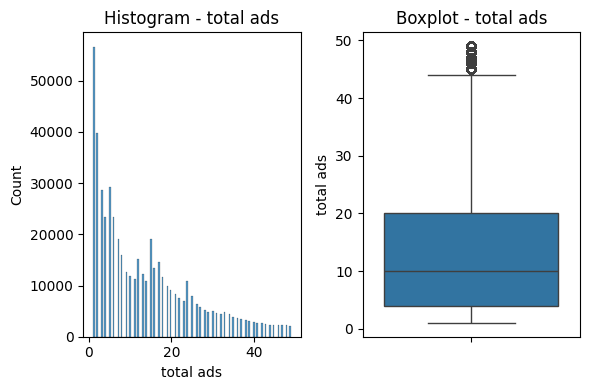

In [ ]:
variable = 'total ads'

plt.figure(figsize=(6, 4))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(x=variable, data=df[df['total ads'] < 50])
plt.title(f'Histogram - {variable}')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=variable, data=df[df['total ads'] < 50])
plt.title(f'Boxplot - {variable}')

# Layout dan tampilan
plt.tight_layout()
plt.show()

Distribusi miring ke kanan (right-skewed) → mayoritas user hanya melihat sedikit iklan.

Puncak frekuensi ada di angka sangat rendah (0–5 ads).

Semakin tinggi jumlah iklan, semakin sedikit jumlah user yang mengalami (frekuensi menurun tajam).

# Bivariate Analysis

In [ ]:
# Menampilkan kolom-kolom pada DataFrame
df.columns

Index(['test group', 'converted', 'total ads', 'most ads day',
       'most ads hour'],
      dtype='object')

In [ ]:
# Membuat tabel kontingensi antara 'test group' dan 'converted'
ct_conversion_test_group = pd.crosstab(df['test group'], df['converted'], normalize='index')
ct_conversion_test_group


converted,False,True
test group,,
ad,0.974453,0.025547
psa,0.982146,0.017854


Grup ad

Tidak conversion (False) = 97.45%

conversion (True) = 2.55%

Grup psa

Tidak conversion (False) = 98.21%

conversion (True) = 1.79%

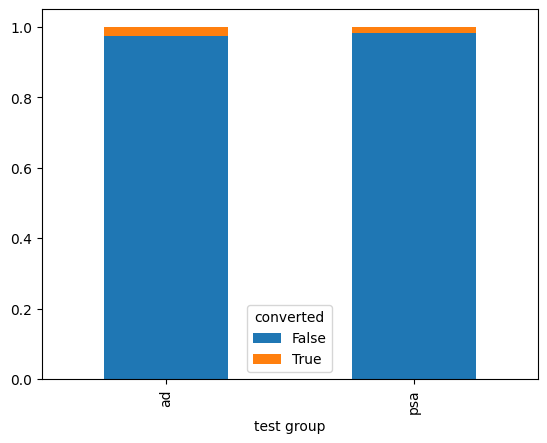

In [ ]:
# Membuat plot bar dari tabel kontingensi di atas
ct_conversion_test_group.plot.bar(stacked=True);

converted        False     True 
most ads day                    
Monday        0.967188  0.032812
Tuesday       0.970160  0.029840
Wednesday     0.975058  0.024942
Sunday        0.975524  0.024476
Friday        0.977788  0.022212
Thursday      0.978429  0.021571
Saturday      0.978949  0.021051


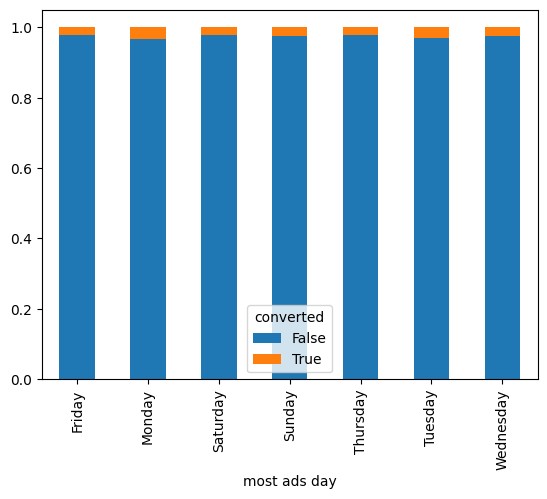

In [ ]:
# Membuat tabel kontingensi antara 'most ads day' dan 'converted'
ct_conversion_day = pd.crosstab(df['most ads day'], df['converted'], normalize='index')
print(ct_conversion_day.sort_values(by=True, ascending=False))
ct_conversion_day.plot.bar(stacked=True);


paling banyak melihat iklan dan kemudian membeli pada hari senin

converted         False     True 
most ads hour                    
16             0.969228  0.030772
20             0.970197  0.029803
15             0.970347  0.029653
21             0.971077  0.028923
17             0.971790  0.028210
14             0.971937  0.028063
18             0.972620  0.027380
19             0.973280  0.026720
22             0.973895  0.026105
13             0.975323  0.024677
12             0.976172  0.023828
23             0.977338  0.022662
6              0.977756  0.022244
11             0.977884  0.022116
10             0.978479  0.021521
5              0.979085  0.020915
8              0.980484  0.019516
9              0.980809  0.019191
0              0.981575  0.018425
7              0.981889  0.018111
4              0.984765  0.015235
1              0.987089  0.012911
3              0.989548  0.010452
2              0.992687  0.007313


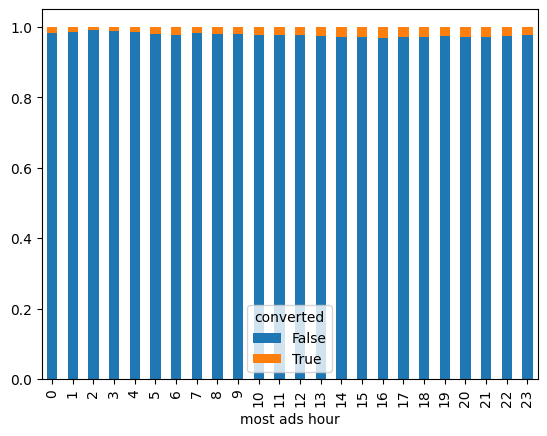

In [ ]:
# Membuat tabel kontingensi antara 'most ads hour' dan 'converted'
ct_conversion_hour = pd.crosstab(df['most ads hour'], df['converted'], normalize='index')
print(ct_conversion_hour.sort_values(by=True, ascending=False))
ct_conversion_hour.plot.bar(stacked=True);


customer yang melihat iklan dan membeli terjadi pada pukul 16.00

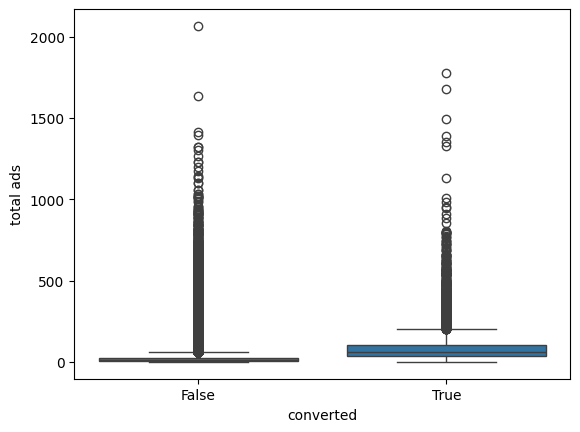

In [ ]:
# Membuat boxplot untuk melihat distribusi 'total ads' berdasarkan status 'converted'
sns.boxplot(x='converted', y='total ads', data=df);

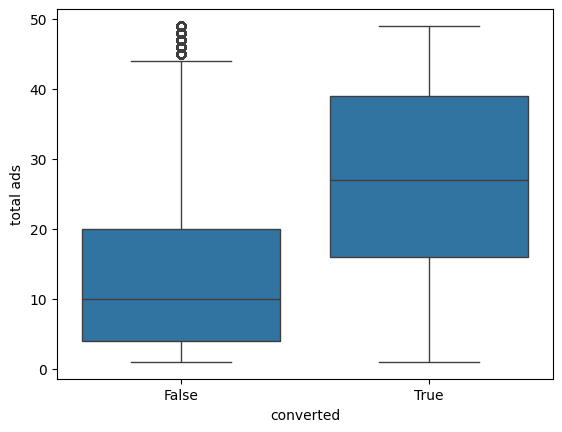

In [ ]:
# Membuat boxplot yang sama, tetapi dengan data yang difilter (total ads < 50) untuk visualisasi yang lebih baik
sns.boxplot(x='converted', y='total ads', data=df[df['total ads'] < 50]);

In [ ]:
from scipy.stats import chi2_contingency

alpha = 0.05

for variable in df_cat.columns:
    if variable != 'converted':
        # Membuat tabel kontingensi (cross-tabulation)
        contingency_table = pd.crosstab(df_cat[variable], df_cat['converted'])

        # Melakukan uji chi-squared
        chi2, p, _, _ = chi2_contingency(contingency_table)

        # Menampilkan hasil
        print(f"\nChi-squared test for {variable} vs. converted:")
        print(f"Chi-squared value: {chi2}")
        print(f"P-value: {p}")

        # Cek signifikansi
        if p < alpha:
            print(f"The difference in conversion rates across {variable} is statistically significant.")
        else:
            print(f"There is no significant difference in conversion rates across {variable}.")


Chi-squared test for test group vs. converted:
Chi-squared value: 54.005823883685245
P-value: 1.9989623063390075e-13
The difference in conversion rates across test group is statistically significant.

Chi-squared test for most ads day vs. converted:
Chi-squared value: 410.0478857936585
P-value: 1.932184379244731e-85
The difference in conversion rates across most ads day is statistically significant.

Chi-squared test for most ads hour vs. converted:
Chi-squared value: 430.76869230822086
P-value: 8.027629823696771e-77
The difference in conversion rates across most ads hour is statistically significant.


Test group vs. converted

Chi-squared value = 54.01

P-value = 1.99e-13 (sangat kecil)

Signifikan -> Conversion rate berbeda secara nyata antara grup ad dan psa.

<br>

Most ads day vs. converted

Chi-squared value = 410.05

P-value = 1.93e-85 (sangat kecil)

Signifikan -> Hari penayangan iklan berpengaruh signifikan terhadap tingkat konversi.

<br>


Most ads hour vs. converted

Chi-squared value = 430.77

P-value = 8.03e-77 (sangat kecil)

Signifikan -> Jam penayangan iklan juga berpengaruh signifikan terhadap konversi.

<br>

artinya jumlah tayangan iklan baik itu hari atapun jam semuanya punya pengaruh signifikan terhadap daya beli customer.

Dengan kata lain, strategi iklan yang tepat (jenis, hari, jam) bisa meningkatkan peluang daya beli customer.

In [ ]:
# Menampilkan kolom-kolom pada DataFrame kategorikal (untuk referensi)
df_cat.columns

Index(['test group', 'converted', 'most ads day', 'most ads hour'], dtype='object')

## cek dulu asumsi dasar data.

In [ ]:
# Impor library yang diperlukan untuk pengujian statistik
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

# Langkah 1: Cek Asumsi
# Asumsi Normalitas (Shapiro-Wilk test)
shapiro_p_value_true = shapiro(df[df['converted'] == True]['total ads'])[1]
shapiro_p_value_false = shapiro(df[df['converted'] == False]['total ads'])[1]
print(f"Shapiro-Wilk test for normality (True group): p-value = {shapiro_p_value_true}")
print(f"Shapiro-Wilk test for normality (False group): p-value = {shapiro_p_value_false}")

# Asumsi Kesetaraan Varians (Levene's test)
levene_p_value = levene(
    df[df['converted'] == True]['total ads'],
    df[df['converted'] == False]['total ads']
)[1]
print(f"Levene's test for equality of variances: p-value = {levene_p_value}")

Shapiro-Wilk test for normality (True group): p-value = 1.638680987007771e-98
Shapiro-Wilk test for normality (False group): p-value = 9.883049430735801e-204
Levene's test for equality of variances: p-value = 0.0


Shapiro-Wilk test (Normalitas):

Grup converted = True → p-value = 1.63e-98 (≪ 0.05) → Tidak normal

Grup converted = False → p-value = 9.88e-204 (≪ 0.05) → Tidak normal

 Kesimpulan: Kedua grup tidak berdistribusi normal.

Levene’s test (Kesetaraan Varians):

p-value = 0.0 (≪ 0.05) → Varians antar grup tidak sama

Kesimpulan: Varians juga tidak homogen.


Karena normalitas tidak terpenuhi dan varians tidak setara, maka independent two-sample t-test TIDAK bisa dipakai.

In [ ]:
# Step 2: Lakukan Uji Statistik yang Sesuai
alpha = 0.05

if (shapiro_p_value_true > alpha) and (shapiro_p_value_false > alpha) and (levene_p_value > alpha):
    # Asumsi terpenuhi - gunakan independent two-sample t-test untuk membandingkan mean
    t_stat, t_p_value = ttest_ind(
        df[df['converted'] == True]['total ads'],
        df[df['converted'] == False]['total ads']
    )
    print(f"Independent two-sample t-test: p-value = {t_p_value}")
else:
    # Asumsi tidak terpenuhi - gunakan Mann-Whitney U test untuk membandingkan median
    u_stat, u_p_value = mannwhitneyu(
        df[df['converted'] == True]['total ads'],
        df[df['converted'] == False]['total ads']
    )
    print(f"Mann-Whitney U test: p-value = {u_p_value}")

Mann-Whitney U test: p-value = 0.0


Hasil Mann-Whitney U test

p-value = 0.0 (sangat kecil, jauh di bawah α = 0.05)

Ada perbedaan signifikan dalam distribusi jumlah iklan yang dilihat (total ads) antara pengguna yang converted (True) dan yang tidak converted (False).

<br>

coclusion

“Jumlah iklan yang ditampilkan (total ads) memiliki hubungan signifikan dengan peluang konversi. Semakin tepat pengaturan frekuensi iklan, semakin besar peluang meningkatkan conversion rate.”